Data from: https://www.datascience4business.com/01_pdsm-tps-optin-a that is a version of: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

The major difference between this two sources are that 3 columns are missing from one to the other: MonthlyRate, HourlyRate, DailyRate. This will not affect the results since there were columns that we could not understood completely and their information could be replaced by MonthlyIncome. Also, there are missing values in the first one but not in the second. I discover this, after the missing values analysis, when trying to reproduce the results in the second dataset. 

This project is intended to understand and quantify the problem of the data scientist resignation. I will try to model and automatize the notification of the employers with more risk to quit and analyze the reasons why they are leaving. 

Since the dataset is in spanish, I will keep a dictionary to translate the name of the columns

In [49]:
spanish_english_cols_dict = {'edad': 'age', 'abandono': 'resignation', 'viajes': 'travel', 'departamento': 'department',
                             'distancia_casa': 'distance_home', 'educacion': 'education', 'carrera': 'career', 
                             'empleados': 'employees', 'satisfaccion_entorno': 'env_satisfaction', 'sexo': 'sex',
                             'implicacion': 'implication', 'nivel_laboral': 'labour_level', 'puesto': 'job',
                             'satisfaccion_trabajo': 'job_satisfaction', 'estado_civil': 'marital_status', 
                             'salario_mes': 'monthly_salary', 'num_empresas_anteriores': 'num_previous_companies',
                             'mayor_edad': 'is_adult', 'horas_extra': 'extra_hours', 
                             'incremento_salario_porc': 'porc_salary_imprevement', 'evaluacion': 'evaluation',
                             'satisfaccion_companeros': 'coworkers_satisfaction', 'horas_quincena': 'fortnight_hours',
                             'nivel_acciones': 'action_level', 'anos_experiencia': 'years_experience',
                             'num_formaciones_ult_ano': 'num_education_last_year', 'conciliacion': 'reconciliation', 
                             'anos_compania': 'years_company', 'anos_en_puesto': 'years_in_job', 
                             'anos_desde_ult_promocion': 'years_since_last_promotion',
                             'anos_con_manager_actual': 'years_with_current_manager'}

spanish_english_values = {'Universitaria': 'University', 'Secundaria': 'Secondary', 'Primaria': 'Elementary', 
                          'Alta': 'High', 'Muy_Alta': 'Very_High', 'Media': 'Medium', 'Baja': 'Low'}

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import matplotlib
from itertools import chain, combinations
import tools.extend_pandas
%load_ext autoreload
%autoreload 2

In [3]:
ds_attrition = pd.read_csv('data/AbandonoEmpleados.csv', sep=';')
ds_attrition.columns = pd.Series(ds_attrition.columns).replace(spanish_english_cols_dict)
ds_attrition.replace(spanish_english_values, inplace=True)
ds_attrition.dtypes

age                             int64
resignation                    object
travel                         object
department                     object
distance_home                   int64
education                      object
career                         object
employees                       int64
id                              int64
env_satisfaction               object
sex                           float64
implication                    object
labour_level                    int64
job                            object
job_satisfaction               object
marital_status                 object
monthly_salary                  int64
num_previous_companies          int64
is_adult                       object
extra_hours                    object
porc_salary_imprevement         int64
evaluation                     object
coworkers_satisfaction         object
fortnight_hours                 int64
action_level                    int64
years_experience                int64
num_educatio

In [4]:
ds_attrition.head()

,age,resignation,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,coworkers_satisfaction,fortnight_hours,action_level,years_experience,num_education_last_year,reconciliation,years_company,years_in_job,years_since_last_promotion,years_with_current_manager
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,Low,80,0,8,0,#N/D,6,NaN,0,5
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,Very_High,80,1,10,3,#N/D,10,NaN,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,Medium,80,0,7,3,#N/D,0,2.0,0,0
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,High,80,0,8,3,#N/D,8,3.0,3,0
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,Very_High,80,1,6,3,#N/D,2,NaN,2,2


# Data Quality

I will analyze the completeness, uniqueness and validity of the data and I will take for granted the timeliness, the consistency and the accuracy of the data.

## Completeness: missing values

The best technique I found to find out missing values, since there are not necessarily NaN but can be any value, is making a frequency table in order to see if there is any value that can represent the missing value, and what percentage it represents. But what it is true, is that the id ends in 2068 and there is 1470 rows so this dataset has some implicit missing data since there are missing employees.

## Uniqueness

The id column ensures the uniqueness of each row and looking at the frequency table, we can see that there is no duplicates in this dataset

## Validity

With the frequency table, we can see if there is any possible error outlier or value that does not make sense considering the meaning of the column, for instance, an age of 1500. There is no wrong values at first sight.

In [5]:
ds_attrition.columns

Index(['age', 'resignation', 'travel', 'department', 'distance_home',
       'education', 'career', 'employees', 'id', 'env_satisfaction', 'sex',
       'implication', 'labour_level', 'job', 'job_satisfaction',
       'marital_status', 'monthly_salary', 'num_previous_companies',
       'is_adult', 'extra_hours', 'porc_salary_imprevement', 'evaluation',
       'coworkers_satisfaction', 'fortnight_hours', 'action_level',
       'years_experience', 'num_education_last_year', 'reconciliation',
       'years_company', 'years_in_job', 'years_since_last_promotion',
       'years_with_current_manager'],
      dtype='object')

In [22]:
possible_columns_with_na = ds_attrition.missing.missing_scan_count_with_default_na_representation(show_zeros=False)
display(possible_columns_with_na)
ds_attrition.missing.print_value_counts_per_column(variables=possible_columns_with_na['variable'])

,variable,n,pct,original_type
8,id,1,0.068027,int64
17,num_previous_companies,197,13.401361,int64
24,action_level,631,42.925170,int64
25,years_experience,11,0.748299,int64
26,num_education_last_year,54,3.673469,int64
28,years_company,44,2.993197,int64
30,years_since_last_promotion,581,39.523810,int64
31,years_with_current_manager,263,17.891156,int64


------------ id ------------
1       1
1391    1
1389    1
1387    1
1383    1
       ..
659     1
657     1
656     1
655     1
2068    1
Name: id, Length: 1470, dtype: int64


------------ num_previous_companies ------------
1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: num_previous_companies, dtype: int64


------------ action_level ------------
0    631
1    596
2    158
3     85
Name: action_level, dtype: int64


------------ years_experience ------------
10    202
6     125
8     103
9      96
5      88
7      81
1      81
4      63
12     48
3      42
15     40
16     37
11     36
13     36
21     34
17     33
2      31
14     31
20     30
18     27
19     22
23     22
22     21
24     18
25     14
28     14
26     14
0      11
29     10
31      9
32      9
30      7
33      7
27      7
36      6
34      5
37      4
35      3
40      2
38      1
Name: years_experience, dtype: int64


------------ num_education_last_year ---------

In [21]:
ds_attrition


,age,resignation,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,coworkers_satisfaction,fortnight_hours,action_level,years_experience,num_education_last_year,reconciliation,years_company,years_in_job,years_since_last_promotion,years_with_current_manager
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,Low,80,0,8,0,NaN,6,NaN,0,5
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,Very_High,80,1,10,3,NaN,10,NaN,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,Medium,80,0,7,3,NaN,0,2.0,0,0
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,High,80,0,8,3,NaN,8,3.0,3,0
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,Very_High,80,1,6,3,NaN,2,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,Research & Development,23,Master,Medical,1,2061,High,...,High,80,1,17,3,NaN,5,4.0,0,3
1466,39,No,Travel_Rarely,Research & Development,6,Secondary,Medical,1,2062,Very_High,...,Low,80,1,9,5,NaN,7,NaN,1,7
1467,27,No,Travel_Rarely,Research & Development,4,Master,Life Sciences,1,2064,Medium,...,Medium,80,1,6,0,NaN,6,NaN,0,3
1468,49,No,Travel_Frequently,Sales,2,Secondary,Medical,1,2065,Very_High,...,Very_High,80,0,17,3,NaN,9,NaN,0,8


It seems that the occurrences of the number 0 in this dataset are meaningful and not representing NaNs so I will be analyzing the same skipping it.

In [23]:
possible_columns_with_na = ds_attrition.missing.missing_scan_count_with_default_na_representation([0, 99, 999], show_zeros=False)
display(possible_columns_with_na)
ds_attrition.missing.print_value_counts_per_column(variables=possible_columns_with_na['variable'])

['0', '-1', '99', '999', '-99', '-999', '-', 'NA', 'N/A', 'NULL', 'NIL', 'EMPTY', '', '#N/D', '-', 'Na', 'N/a', 'Null', 'Nil', 'Empty', '', '#n/d', datetime.datetime(1970, 1, 1, 0, 0), datetime.datetime(1900, 1, 1, 0, 0), datetime.datetime(2099, 12, 31, 0, 0), datetime.datetime(2999, 12, 31, 0, 0), datetime.datetime(9999, 12, 31, 0, 0), '-', 'na', 'n/a', 'null', 'nil', 'empty', '', '#n/d', '1970-01-01', '1900-01-01', '2099-12-31', '2999-12-31', '9999-12-31', -1, -99, -999]


,variable,n,pct,original_type


There is only #N/D left as possible NaN value

In [24]:
ds_attrition.replace({'#N/D': np.nan}, inplace=True)
perc_null = ds_attrition.isnull().mean()
perc_null[perc_null > 0].sort_values()

implication         0.012245
job_satisfaction    0.051701
education           0.068707
sex                 0.135374
reconciliation      0.687755
years_in_job        0.842177
dtype: float64

In [32]:
ds_attrition.missing.print_value_counts_per_column()

------------ age ------------
35    78
34    77
36    69
31    69
29    68
32    61
30    60
33    58
38    58
40    57
37    50
27    48
28    48
42    46
39    42
45    41
41    40
26    39
44    33
46    33
43    32
50    30
25    26
24    26
49    24
47    24
55    22
51    19
53    19
48    19
54    18
52    18
22    16
56    14
23    14
58    14
21    13
20    11
59    10
19     9
18     8
60     5
57     4
Name: age, dtype: int64


------------ resignation ------------
No     1233
Yes     237
Name: resignation, dtype: int64


------------ travel ------------
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: travel, dtype: int64


------------ department ------------
Research & Development    961
Sales                     446
Human Resources            63
Name: department, dtype: int64


------------ distance_home ------------
2     211
1     208
10     86
9      85
3      84
7      84
8      80
5      65
4      64
6      59
16     32
11     29
2

It does not seem like there is any other missing value

Reconciliation and years_in_job have a lot of missing values, which makes them a good candidates to be deleted. I will have to take care of the others. I will analyze if there is a possible pattern between them or with the target.

In [123]:
missing_per_rows = ds_attrition.missing.missing_case_summary()
missing_per_rows.value_counts('n_missing')

n_missing
2    762
1    451
3    164
0     58
6     18
4     17
dtype: int64

In [136]:
four_missing_cases = missing_per_rows.loc[missing_per_rows['n_missing'] == 4, 'case'].values
ds_attrition.iloc[four_missing_cases].missing.missing_variable_summary(show_zeros=False)

,variable,n_missing,pct_missing
5,education,13,76.470588
10,sex,14,82.352941
14,job_satisfaction,7,41.176471
27,reconciliation,17,100.000000
29,years_in_job,17,100.000000


In [135]:
six_missing_cases = missing_per_rows.loc[missing_per_rows['n_missing'] == 6, 'case'].values
ds_attrition.iloc[six_missing_cases].missing.missing_variable_summary(show_zeros=False)

,variable,n_missing,pct_missing
5,education,18,100.0
10,sex,18,100.0
11,implication,18,100.0
14,job_satisfaction,18,100.0
27,reconciliation,18,100.0
29,years_in_job,18,100.0


It appears that there is no row with 5 missing values and it seems like those which has 6 missing values has the same 6 columns that could be a pattern. But since there is only 18, I will not take it as any pattern. 

## Pattern missing data analysis

To find patterns in the missing data, I will calculate the correlations for the different columns vs a new column with 1 when the value of a specific column is missing and 0 when it is not. I will use different test depending on the variable type. Since our variable will be binary or dichotomous, I will be using:

- Point-biserial: numerical continuous
- Tetrachronic: binary
- Cramer-V: categorical

The point-biserial, Pearson and Spearman is the same in the case of dichotomous vs dichotomous.

In [27]:
ds_attrition_pattern_md = ds_attrition.missing.bind_shadow_matrix(True, False, only_missing=True)
ds_attrition_pattern_md.head()

,age,resignation,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,years_company,years_in_job,years_since_last_promotion,years_with_current_manager,education_NA,sex_NA,implication_NA,job_satisfaction_NA,reconciliation_NA,years_in_job_NA
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,6,NaN,0,5,False,False,False,False,True,True
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,10,NaN,1,7,False,False,False,False,True,True
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,0,2.0,0,0,False,False,False,False,True,False
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,8,3.0,3,0,False,False,False,False,True,False
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,2,NaN,2,2,False,False,False,False,True,True


In [42]:
def correlation_info(df, corr_method: str = 'pearson', corr_threshold: float = 0.8, missing_suffix: str = '_NA'):
    all_corr = df.corr(method=corr_method)
    corr_missing_data = all_corr[all_corr.index.str.endswith(missing_suffix)]
    corr_missing_data.replace(1.0, np.nan, inplace=True)
    return (corr_missing_data[corr_missing_data.abs() > corr_threshold]
            .dropna(axis=1, how='all')
            .dropna(axis=0, how='all'))

In [43]:
def correlation_pointbiserialr(x, y):
    return stats.pointbiserialr(x, y).correlation

In [44]:
correlation_info(ds_attrition_pattern_md, correlation_pointbiserialr, corr_threshold=0.4)

<ipython-input-42-840864b5e441>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_corr = df.corr(method=corr_method)
c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-42-840864b5e441>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_missing_data.replace(1.0, np.nan, inplace=True)


,education_NA,implication_NA,job_satisfaction_NA
education_NA,NaN,0.409915,NaN
implication_NA,0.409915,NaN,0.476845
job_satisfaction_NA,NaN,0.476845,NaN


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

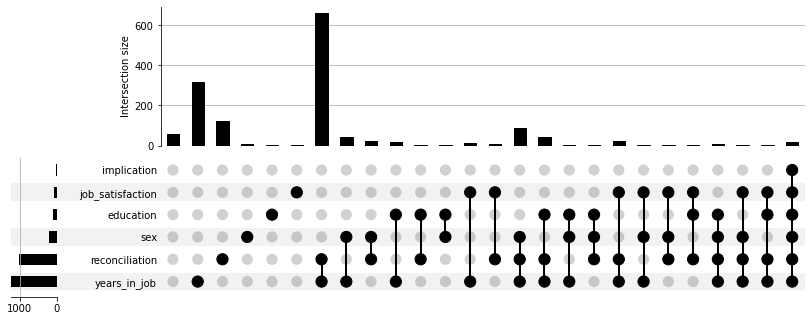

In [105]:
ds_attrition_pattern_md.missing.missing_upsetplot()

It seems that there is no clear pattern in the missing data. All possible coincidences are due to the high number of missing values in years_in_job and reconciliation. Also the correlation analysis has showed the same. 

After some research about the origin of the data, it seems that the original data has not missing values. So, it is probably that the values that are missing are, in fact, missing competely at random from the second data source for education purposes. Knowing that, we can procceed to choose how the missing values are going to be handled.

# EDA and Data Cleaning

First of all, I will delete the columns I saw that has for all the employees the same value since it will not apport any extra information. That columns were: employees, is_adult, fortnight_hours

Since I concluded that the missing are at random, I will delete the columns years in job and reconciliation because of the % of missing data.

In [140]:
ds_attrition_pattern_md.head()

,age,resignation,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,years_company,years_in_job,years_since_last_promotion,years_with_current_manager,education_NA,sex_NA,implication_NA,job_satisfaction_NA,reconciliation_NA,years_in_job_NA
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,6,NaN,0,5,False,False,False,False,True,True
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,10,NaN,1,7,False,False,False,False,True,True
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,0,2.0,0,0,False,False,False,False,True,False
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,8,3.0,3,0,False,False,False,False,True,False
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,2,NaN,2,2,False,False,False,False,True,True


The column 'sex' has values from 1 to 4 and also has +10% of missing values, so I will drop it since I cannot understand what this values represents.

In [141]:
ds_attrition.drop(['employees', 'is_adult', 'fortnight_hours', 'reconciliation', 'years_in_job', 'sex'], axis=1, inplace=True)

In [142]:
categorical_features = ds_attrition.dtypes[ds_attrition.dtypes=='object'].index
numerical_features = ds_attrition.dtypes[ds_attrition.dtypes!='object'].index

In [143]:
ds_attrition.loc[:, numerical_features].tail()

,age,distance_home,id,labour_level,monthly_salary,num_previous_companies,porc_salary_imprevement,action_level,years_experience,num_education_last_year,years_company,years_since_last_promotion,years_with_current_manager
1465,36,23,2061,2,2571,4,17,1,17,3,5,0,3
1466,39,6,2062,3,9991,4,15,1,9,5,7,1,7
1467,27,4,2064,2,6142,1,20,1,6,0,6,0,3
1468,49,2,2065,2,5390,2,14,0,17,3,9,0,8
1469,34,8,2068,2,4404,2,12,0,6,3,4,1,2


In [144]:
ds_attrition.loc[:, categorical_features].tail()

,resignation,travel,department,education,career,env_satisfaction,implication,job,job_satisfaction,marital_status,extra_hours,evaluation,coworkers_satisfaction
1465,No,Travel_Frequently,Research & Development,Master,Medical,High,Very_High,Laboratory Technician,Very_High,Married,No,High,High
1466,No,Travel_Rarely,Research & Development,Secondary,Medical,Very_High,Medium,Healthcare Representative,Medium,Married,No,High,Low
1467,No,Travel_Rarely,Research & Development,Master,Life Sciences,Medium,Very_High,Manufacturing Director,Very_High,Married,Yes,Very_High,Medium
1468,No,Travel_Frequently,Sales,Secondary,Medical,Very_High,Medium,Sales Executive,Medium,Married,No,High,Very_High
1469,No,Travel_Rarely,Research & Development,NaN,Medical,Medium,Very_High,Laboratory Technician,Very_High,Married,No,High,Low
